In [1]:
import torchvision
from torchvision import models, datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import scipy.misc as misc
import utils
import os
import numpy as np
from models.Inception_V3_R1.data_loader import Dataloader
import models.Inception_V3_R1.net as net
import time

%load_ext autoreload
%autoreload 2

In [4]:
inception_v3 = models.inception_v3(pretrained=True)

# Instantiating the model from the torch site

In [5]:
inception_v3 = models.inception_v3(pretrained=True)
for param in inception_v3.parameters():
    param.requires_grad = False
#inception_v3

In [6]:
#features = list(inception_v3.fc())
#features = []
#vgg19.classifier = torch.nn.Sequential(*features)
#vgg19
features1 = list(inception_v3.AuxLogits.children())

features2 = list(inception_v3.fc.children())
print(features1)
print(features2)
features = []
inception_v3.fc = nn.Sequential(*features)
inception_v3.fc
inception_v3

[BasicConv2d(
  (conv): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), BasicConv2d(
  (conv): Conv2d(128, 768, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(768, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=768, out_features=1000, bias=True)]
[]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

# Run all the images (resized to 299 X 299 and normalized to 0 mean and stddev =1 ) through the Inception-V3 pretrained network except the final FC layer

In [ ]:
cur_dir = os.getcwd()
print(cur_dir)
json_path = os.path.join(cur_dir,'models/Inception_V3_R1/params.json')
params = utils.Params(json_path)
data_loader = Dataloader(params)

labels_dict = data_loader.load_labels("train", params)
image_dict = data_loader.load_data("train", params)
img_count = len(image_dict)

key_list = []
for item in image_dict:
    key_list.append(item)
key_list[0]

/home/bony/Deep_Learning_Stanford_CS230/Project/Code
/home/bony/Deep_Learning_Stanford_CS230/Project/Data/train_224
train
datatype is train
image id count =  31072


'00070df0-bbc3-11e8-b2bc-ac1f6b6435d0'

In [ ]:
params.cuda = torch.cuda.is_available()

inception_v3_eval = inception_v3.eval().cuda() if params.cuda else inception_v3.eval()

image_feature_dict = {}
img_count =0
t0 = time.time()

for img_id in key_list:

    #img_id = data_loader.get_random_image_id("train", params)
    input_img = data_loader.load_single_image("train", params, img_id).cuda()
    inception_v3_eval_out = inception_v3_eval(input_img)
    output = inception_v3_eval_out.cpu().numpy()
    image_feature_dict[img_id] = output
    
    if (img_count % 500 == 0):
        print(img_count, time.time() -t0)
        t0 = time.time()
    img_count += 1

print('done preprocessing image for inception net')

In [87]:
output = inception_v3_eval_out.cpu().numpy()
output

array([[0.37203035, 0.09217899, 0.27023485, ..., 0.00871159, 0.06991827,
        0.03201964]], dtype=float32)

In [52]:
cur_dir = os.getcwd()
print(cur_dir)
json_path = os.path.join(cur_dir,'models/Inception_V3_R1/params.json')
model_dir = os.path.join(cur_dir, 'models/Inception_V3_R1')
params = utils.Params(json_path)
data_loader = Dataloader(params)
labels_dict = data_loader.load_labels("train", params)

/home/bony/Deep_Learning_Stanford_CS230/Project/Code
/home/bony/Deep_Learning_Stanford_CS230/Project/Data/train


In [53]:
# Shuffle the images for training 
key_list = []
for key in image_feature_dict:
    key_list.append(key)
np.random.shuffle(key_list)
print(key_list[0], key_list[20])



# Define some parameters
image_count = len(labels_dict)
minibatch_size = params.batch_size
num_epochs = params.num_epochs
features_in = params.features_in
channels = 3    

num_batches = (image_count +1) // params.batch_size

print("image count = ", image_count)
print("minibatch_size  = ", minibatch_size)
print("num_epochs = ", num_epochs)
print("features_in  = ", features_in)
print("num_batches  = ", num_batches)
print("learning rate = ", params.learning_rate)

batch_data = torch.zeros([minibatch_size, features_in], dtype=torch.float32)
batch_labels = torch.zeros([minibatch_size, 28], dtype=torch.float32)

# Check if GPU is cuda capable
cuda_present = torch.cuda.is_available()

#Instantiate the model, loss fn, Optimizer
if cuda_present:
    model = net.Net(params).cuda()
else:
    model = net.Net(params)
optimizer = optim.Adam(model.parameters(), lr= params.learning_rate)
criterion = nn.BCELoss()

da5d5f3c-bba4-11e8-b2ba-ac1f6b6435d0 a21f3602-bbba-11e8-b2ba-ac1f6b6435d0
image count =  31072
minibatch_size  =  16
num_epochs =  100
features_in  =  2048
num_batches  =  1942
learning rate =  0.0001


In [54]:
#Train the model over a few epochs
for epoch in range(num_epochs):
    #np.random.shuffle(key_list)
    print("\n******************\n Epoch = ", epoch,"\n")
    for j in range(num_batches):
        mini_batch_index_start = j*minibatch_size
        mini_batch_index_end = (j+1)*minibatch_size
        batch_image_index = key_list[mini_batch_index_start:mini_batch_index_end ]
        #print(j, mini_batch_index_start)
        
        # Generate mini-batch data and labels
        for k in range(minibatch_size):
            img_id = key_list[mini_batch_index_start + k]
            batch_data[k,:] = torch.tensor(image_feature_dict[img_id], dtype= torch.float32)
            labels = torch.tensor(labels_dict[img_id], dtype= torch.float32)
            batch_labels[k, :] = labels
        
        #print(img_id)
        if cuda_present:
            batch_data = batch_data.cuda()
            batch_labels = batch_labels.cuda()
            
        # clear previous gradients
        optimizer.zero_grad()

        #forward propogation
        output_batch = model.forward(batch_data)

        #calculate the loss
        loss = criterion(output_batch,batch_labels)
        
        # backward propogation
        loss.backward()
        
        # performs parameter updates using calculated gradients
        optimizer.step()
        
        #cost = loss.item()
        #print(cost)
        # print statistics
        
        '''
        for param in model.fc1.parameters():
            for k in range(len(param.size())):
                print(param[k])
        ''' 
        if ( (j%200 ==0) or ((j+1)% num_batches ==0) ):
            cost = loss.item()
            #cost = cost.cpu()
            print('Batch #:' + str(j) + ", training cost = " + str(cost))
key_list[0] 
labels_dict[img_id].shape


******************
 Epoch =  0 

Batch #:0, training cost = 0.6962584257125854
Batch #:200, training cost = 0.2033204883337021
Batch #:400, training cost = 0.15681171417236328
Batch #:600, training cost = 0.14521929621696472
Batch #:800, training cost = 0.15073177218437195
Batch #:1000, training cost = 0.17286698520183563
Batch #:1200, training cost = 0.16172567009925842
Batch #:1400, training cost = 0.16046561300754547
Batch #:1600, training cost = 0.13567087054252625
Batch #:1800, training cost = 0.14514930546283722
Batch #:1941, training cost = 0.1741296947002411

******************
 Epoch =  1 

Batch #:0, training cost = 0.15968124568462372
Batch #:200, training cost = 0.20019419491291046
Batch #:400, training cost = 0.1418304443359375
Batch #:600, training cost = 0.14474396407604218
Batch #:800, training cost = 0.13803234696388245
Batch #:1000, training cost = 0.1568545401096344
Batch #:1200, training cost = 0.15620985627174377
Batch #:1400, training cost = 0.14903922379016876
B

Batch #:600, training cost = 0.07424049079418182
Batch #:800, training cost = 0.058421168476343155
Batch #:1000, training cost = 0.08064208179712296
Batch #:1200, training cost = 0.05877092108130455
Batch #:1400, training cost = 0.06003878638148308
Batch #:1600, training cost = 0.07058907300233841
Batch #:1800, training cost = 0.06354384869337082
Batch #:1941, training cost = 0.08332794904708862

******************
 Epoch =  15 

Batch #:0, training cost = 0.09054569900035858
Batch #:200, training cost = 0.08722466975450516
Batch #:400, training cost = 0.07733004540205002
Batch #:600, training cost = 0.06739646196365356
Batch #:800, training cost = 0.05063038691878319
Batch #:1000, training cost = 0.0709855929017067
Batch #:1200, training cost = 0.0517430379986763
Batch #:1400, training cost = 0.053722016513347626
Batch #:1600, training cost = 0.06632296741008759
Batch #:1800, training cost = 0.056813646107912064
Batch #:1941, training cost = 0.07744758576154709

******************
 Ep

Batch #:800, training cost = 0.022969992831349373
Batch #:1000, training cost = 0.017362354323267937
Batch #:1200, training cost = 0.020144183188676834
Batch #:1400, training cost = 0.03388484567403793
Batch #:1600, training cost = 0.025601718574762344
Batch #:1800, training cost = 0.015918666496872902
Batch #:1941, training cost = 0.02994537726044655

******************
 Epoch =  29 

Batch #:0, training cost = 0.03573298454284668
Batch #:200, training cost = 0.01875513233244419
Batch #:400, training cost = 0.0293464045971632
Batch #:600, training cost = 0.028222503140568733
Batch #:800, training cost = 0.016333293169736862
Batch #:1000, training cost = 0.014857837930321693
Batch #:1200, training cost = 0.013233725912868977
Batch #:1400, training cost = 0.027426959946751595
Batch #:1600, training cost = 0.027665963396430016
Batch #:1800, training cost = 0.01871781051158905
Batch #:1941, training cost = 0.0231665950268507

******************
 Epoch =  30 

Batch #:0, training cost = 0.

Batch #:800, training cost = 0.012008381076157093
Batch #:1000, training cost = 0.00845798384398222
Batch #:1200, training cost = 0.005136299412697554
Batch #:1400, training cost = 0.012943061999976635
Batch #:1600, training cost = 0.01333568524569273
Batch #:1800, training cost = 0.012880234979093075
Batch #:1941, training cost = 0.004938341677188873

******************
 Epoch =  43 

Batch #:0, training cost = 0.009479327127337456
Batch #:200, training cost = 0.024244891479611397
Batch #:400, training cost = 0.007937918417155743
Batch #:600, training cost = 0.01886686682701111
Batch #:800, training cost = 0.010045918636023998
Batch #:1000, training cost = 0.010264582931995392
Batch #:1200, training cost = 0.005914271809160709
Batch #:1400, training cost = 0.012803097255527973
Batch #:1600, training cost = 0.007644610945135355
Batch #:1800, training cost = 0.020695943385362625
Batch #:1941, training cost = 0.006615187041461468

******************
 Epoch =  44 

Batch #:0, training cos

Batch #:800, training cost = 0.0015476344851776958
Batch #:1000, training cost = 0.0031199331860989332
Batch #:1200, training cost = 0.0025799700524657965
Batch #:1400, training cost = 0.0055852667428553104
Batch #:1600, training cost = 0.004503822419792414
Batch #:1800, training cost = 0.0030449612531811
Batch #:1941, training cost = 0.0018418041290715337

******************
 Epoch =  57 

Batch #:0, training cost = 0.006775803864002228
Batch #:200, training cost = 0.011236210353672504
Batch #:400, training cost = 0.005749449133872986
Batch #:600, training cost = 0.004626073408871889
Batch #:800, training cost = 0.00679801544174552
Batch #:1000, training cost = 0.008415380492806435
Batch #:1200, training cost = 0.0028442780021578074
Batch #:1400, training cost = 0.006410627625882626
Batch #:1600, training cost = 0.004623671527951956
Batch #:1800, training cost = 0.0006735222414135933
Batch #:1941, training cost = 0.004561820533126593

******************
 Epoch =  58 

Batch #:0, train

Batch #:600, training cost = 0.003584710881114006
Batch #:800, training cost = 0.0010817412985488772
Batch #:1000, training cost = 0.01484412606805563
Batch #:1200, training cost = 0.0016639860114082694
Batch #:1400, training cost = 0.0017385993851348758
Batch #:1600, training cost = 0.0035247814375907183
Batch #:1800, training cost = 0.00420363200828433
Batch #:1941, training cost = 0.0023837611079216003

******************
 Epoch =  71 

Batch #:0, training cost = 0.009290087036788464
Batch #:200, training cost = 0.008293547667562962
Batch #:400, training cost = 0.0017977451207116246
Batch #:600, training cost = 0.006140542682260275
Batch #:800, training cost = 0.002819524612277746
Batch #:1000, training cost = 0.004253131803125143
Batch #:1200, training cost = 0.0015919586876407266
Batch #:1400, training cost = 0.0028564478270709515
Batch #:1600, training cost = 0.0019887094385921955
Batch #:1800, training cost = 0.0022302460856735706
Batch #:1941, training cost = 0.0005214951816014

Batch #:200, training cost = 0.0010356655111536384
Batch #:400, training cost = 0.009399237111210823
Batch #:600, training cost = 0.007221837993711233
Batch #:800, training cost = 0.0014807202387601137
Batch #:1000, training cost = 0.005768573842942715
Batch #:1200, training cost = 0.003623223165050149
Batch #:1400, training cost = 0.0020630902145057917
Batch #:1600, training cost = 0.0014951881021261215
Batch #:1800, training cost = 0.0007463571382686496
Batch #:1941, training cost = 0.0009778219973668456

******************
 Epoch =  85 

Batch #:0, training cost = 0.0028934055007994175
Batch #:200, training cost = 0.010765129700303078
Batch #:400, training cost = 0.009211628697812557
Batch #:600, training cost = 0.0008244792115874588
Batch #:800, training cost = 0.0022671481128782034
Batch #:1000, training cost = 0.00046362497960217297
Batch #:1200, training cost = 0.001881999894976616
Batch #:1400, training cost = 0.00250605633482337
Batch #:1600, training cost = 0.0010427893139421

Batch #:200, training cost = 0.0032806829549372196
Batch #:400, training cost = 0.0013825384667143226
Batch #:600, training cost = 0.0030412061605602503
Batch #:800, training cost = 0.0007839394966140389
Batch #:1000, training cost = 0.0005462670815177262
Batch #:1200, training cost = 0.002419086406007409
Batch #:1400, training cost = 0.0016834094421938062
Batch #:1600, training cost = 0.0005589540232904255
Batch #:1800, training cost = 0.0032788687385618687
Batch #:1941, training cost = 0.0013830476673319936

******************
 Epoch =  99 

Batch #:0, training cost = 0.003833186347037554
Batch #:200, training cost = 0.009618292562663555
Batch #:400, training cost = 0.003160465508699417
Batch #:600, training cost = 0.0016678154934197664
Batch #:800, training cost = 0.0019480297341942787
Batch #:1000, training cost = 0.001072492334060371
Batch #:1200, training cost = 0.0005508613539859653
Batch #:1400, training cost = 0.00044623849680647254
Batch #:1600, training cost = 0.004194817505

(28,)

In [55]:
state = {'epoch':100, 'state_dict':model.state_dict(), 'optim_dict':optimizer.state_dict()}

In [59]:
file_path = os.path.join(cur_dir, 'models/Inception_V3_R1/epoch100.pth.tar')
torch.save(state, file_path)

In [ ]:


inception_v3_eval = inception_v3.eval()
image_feature_dict = {}
image_dict = data_loader.load_data("train", params)
img_count = 0
t0 = time.time()
for img_id in image_dict:
    if (img_count %50 == 0):
        t1 = time.time()
        print("image count = ", img_count, t1-t0)
        t0 = t1
    input_img = data_loader.load_single_image("train", params, img_id)
    inception_v3_eval_out = inception_v3_eval(input_img)
    image_feature_dict[img_id] = inception_v3_eval_out

    img_count += 1

print("Finished evaluation, next step is to save the data to file")


key_list = []
for item in image_feature_dict:
    key_list.append(item)
f = open("image_resize299_inception_v3_feature.txt", "w")
for item in key_list:
    val = str(image_feature_dict[item].tolist())
    f.write(item+":"+val+"\n")
f.close()

/home/bony/Deep_Learning_Stanford_CS230/Project/Code
/home/bony/Deep_Learning_Stanford_CS230/Project/Data/train
train
datatype is train
image id count =  31072
image count =  0 0.00017762184143066406


In [151]:
import seaborn as sns
import matplotlib as mpl

[1.2885e+04 1.2540e+03 3.6210e+03 1.5610e+03 1.8580e+03 2.5130e+03
 1.0080e+03 2.8220e+03 5.3000e+01 4.5000e+01 2.8000e+01 1.0930e+03
 6.8800e+02 5.3700e+02 1.0660e+03 2.1000e+01 5.3000e+02 2.1000e+02
 9.0200e+02 1.4820e+03 1.7200e+02 3.7770e+03 8.0200e+02 2.9650e+03
 3.2200e+02 8.2280e+03 3.2800e+02 1.1000e+01]


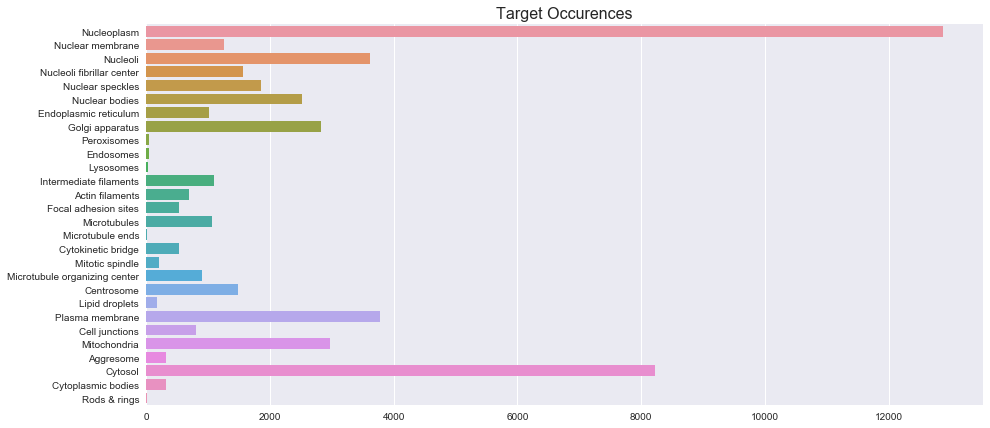

In [160]:
# Target labels
LABEL_MAP = {
    0: "Nucleoplasm",
    1: "Nuclear membrane",
    2: "Nucleoli",
    3: "Nucleoli fibrillar center",   
    4: "Nuclear speckles",
    5: "Nuclear bodies",
    6: "Endoplasmic reticulum",
    7: "Golgi apparatus",
    8: "Peroxisomes",
    9:  "Endosomes",
    10: "Lysosomes",
    11: "Intermediate filaments", 
    12: "Actin filaments",
    13: "Focal adhesion sites",
    14: "Microtubules",
    15: "Microtubule ends",
    16: "Cytokinetic bridge",
    17: "Mitotic spindle",
    18: "Microtubule organizing center",  
    19: "Centrosome",
    20: "Lipid droplets",
    21: "Plasma membrane",
    22: "Cell junctions",
    23: "Mitochondria",
    24: "Aggresome",
    25: "Cytosol",
    26: "Cytoplasmic bodies",
    27: "Rods & rings"
}

# Defines
DIM_HEIGHT = DIM_WIDTH = 512
N_CHANNELS = 4

label = np.zeros((28))
for j in range(len(labels_dict)):
    item = key_list[j]
    tgt_label = labels_dict[item]
    label += tgt_label
    
print(label)
xx = list(LABEL_MAP.values())

plt.figure(figsize=(15, 7))
mpl.style.use('seaborn-darkgrid')
sns.barplot(x = label, y = xx)
plt.title('Target Occurences', fontsize=16)
plt.show()


In [167]:
params.train_data_path

'C:\\Users\\rsbandhu\\Documents\\MUSTBACKUP\\Details\\Computers\\DeepLearning_Stanford_CS230\\Project\\all\\train'

# Instantiating the model and initializing the weights from my laptop, downloaded from the torch sitem the local machine. Don't need this now

In [8]:
from models.VGG19_1.vgg import VGG
#from models import vgg
vgg19_bn = VGG.vgg19_bn(pretrained=False)
curdir = os.getcwd()
vgg_dict_path = os.path.join(curdir, "models/VGG19_1/vgg19_bn-c79401a0.pth")
model_vgg19_bn.load_state_dict(torch.load(vgg_dict_path))

for param in model_vgg19_bn.parameters():
    param.requires_grad = False

AttributeError: type object 'VGG' has no attribute 'vgg19_bn'

In [74]:
for x in model_vgg19_bn.classifier.children():
    print(x)
    for y in x.parameters():
        print(y.requires_grad)
for x in model_vgg19_bn.modules():
    print(x.state_dict().keys())
import json
cur_dir = os.getcwd()
print(cur_dir)
json_path = os.path.join(cur_dir,'models\params.json')
f = open(json_path)
params = json.load(f)
#params = utils.Params(json_path)
data_loader = Dataloader(params)

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.20.weight', 'features.20.bias', 'features.21.weight', 'features.21.bias', 'features.21.running_mean', 'features.21.running_var', 'features.23.weight', 'features.2

In [66]:
torch.cuda.get_device_name(0)

'GeForce GTX 1050 Ti'

In [60]:
cur_dir

'/home/bony/Deep_Learning_Stanford_CS230/Project/Code'

In [61]:
from models.Inception_V3_

'/home/bony/Deep_Learning_Stanford_CS230/Project/Code'